# CNNGeometric demo notebook
This notebook shows how to run a trained model on a given image pair

## Imports

In [1]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf, AffineGridGenV2
from geotnf.stitching_grid_gen import StitchingAffineGridGen
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize,Compose
from collections import OrderedDict
# import cv2 as cv

warnings.filterwarnings('ignore')

## Parameters

In [2]:
feature_extraction_cnn = 'resnet101'
# feature_extraction_cnn = 'vgg'

model_hom_path = ''

if feature_extraction_cnn=='vgg':
    # model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss.pth.tar'
    # model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss.pth.tar'
    # model_hom_path = 'trained_models/best_pascal_checkpoint_adam_hom_grid_loss_PAMI.pth.tar'
    model_aff_path = 'trained_models/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar'
    model_tps_path = 'trained_models/best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar'   
    model_hom_path = 'trained_models/best_streetview_checkpoint_adam_hom_grid_loss_PAMI.pth.tar'   
elif feature_extraction_cnn=='resnet101':
    # model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'
    model_aff_path = 'trained_models/affine_no_occ/best_affine_no_occ_affine_grid_lossresnet101.pth.tar'
    # model_tps_path = 'trained_models/checkpoint_adam/best_checkpoint_adam_tps_grid_lossresnet101_no_occluded.pth.tar'   
    model_tps_4p_path = "trained_models/tps_4p_no_occ/best_tps_4p_no_occ_tps_grid_lossresnet101.pth.tar"
    model_tps_8p_path = "trained_models/tps_8p_no_occ/best_tps_8p_no_occ_tps_grid_lossresnet101.pth.tar"
    # model_tps_8p_path = "" 
    model_tps_9p_path = "trained_models/tps_9p_no_occ/best_tps_9p_no_occ_tps_grid_lossresnet101.pth.tar"
    model_hom_path = 'trained_models/hom_no_occ/best_hom_no_occ_hom_grid_lossresnet101.pth.tar'   



source_image_path='datasets/PF-dataset/duck(S)/060_0036.png'
target_image_path='datasets/PF-dataset/duck(S)/060_0013.png'

# source_image_path='datasets/tokyoTimeMachine/images/-6/-6mVZfATe2_oFF731dr9fA/_200909/-6mVZfATe2_oFF731dr9fA__200909_35.657335_139.681878_000_012.jpg'
# target_image_path='datasets/tokyoTimeMachine/images/-6/-6mVZfATe2_oFF731dr9fA/_200909/-6mVZfATe2_oFF731dr9fA__200909_35.657335_139.681878_030_012.jpg'
visual_grid_path = 'datasets/testDataset/visual_grid.jpg'

# source_image_path='datasets/testDataset/test-scene/partial_pictures/affine_img.jpg'
# source_image_path='datasets/testDataset/random/Frame31.jpg'
# source_image_path='datasets/testDataset/random/Frame31.jpg'
# target_image_path='datasets/testDataset/random/Frame30.jpg'
full_source_image_path='datasets/testDataset/random/3.jpg'

## Load models

In [3]:
use_cuda = torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps_9p = not model_tps_9p_path==''
do_tps_8p = not model_tps_8p_path==''
do_tps_4p = not model_tps_4p_path==''
do_hom = not model_hom_path==''

# Create model
print('Creating CNN model...')
if do_aff:
    model_aff = CNNGeometric(use_cuda=use_cuda,output_dim=6,feature_extraction_cnn=feature_extraction_cnn)
if do_tps_9p:
    # model_tps = CNNGeometric(use_cuda=use_cuda,output_dim=18,feature_extraction_cnn=feature_extraction_cnn)
    model_tps_9p = CNNGeometric(use_cuda=use_cuda,output_dim=18,feature_extraction_cnn=feature_extraction_cnn)
if do_tps_8p:
    # model_tps = CNNGeometric(use_cuda=use_cuda,output_dim=18,feature_extraction_cnn=feature_extraction_cnn)
    model_tps_8p = CNNGeometric(use_cuda=use_cuda,output_dim=16,feature_extraction_cnn=feature_extraction_cnn)
if do_tps_4p:
    # model_tps = CNNGeometric(use_cuda=use_cuda,output_dim=18,feature_extraction_cnn=feature_extraction_cnn)
    model_tps_4p = CNNGeometric(use_cuda=use_cuda,output_dim=8,feature_extraction_cnn=feature_extraction_cnn)
if do_hom:
    model_hom = CNNGeometric(use_cuda=use_cuda,output_dim=8,feature_extraction_cnn=feature_extraction_cnn)
    
# Load trained weights
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
if do_tps_9p:
    checkpoint = torch.load(model_tps_9p_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps_9p.load_state_dict(checkpoint['state_dict'])
if do_tps_8p:
    checkpoint = torch.load(model_tps_8p_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps_8p.load_state_dict(checkpoint['state_dict'])
if do_tps_4p:
    checkpoint = torch.load(model_tps_4p_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps_4p.load_state_dict(checkpoint['state_dict'])
if do_hom:
    checkpoint = torch.load(model_hom_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_hom.load_state_dict(checkpoint['state_dict'])

Creating CNN model...
Loading trained model weights...


## Create image transformers

In [4]:
tpsTnf_9p = GeometricTnf(geometric_model='tps', use_cuda=use_cuda,reg_grid=True)
tpsTnf_8p = GeometricTnf(geometric_model='tps', use_cuda=use_cuda,reg_grid=False,x_axis_coords=[-1,-1,-1,0,0,1,1,1],y_axis_coords=[-1,0,1,-1,1,-1,0,1])
tpsTnf_4p = GeometricTnf(geometric_model='tps', use_cuda=use_cuda,reg_grid=False,x_axis_coords=[-1,-1,1,1],y_axis_coords=[-1,1,-1,1])
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
homTnf = GeometricTnf(geometric_model='hom', use_cuda=use_cuda)

## Load and preprocess images

In [5]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

Text(0.5, 1.0, 'full_src')

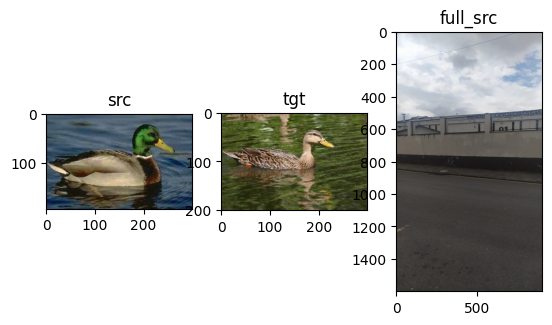

In [6]:
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)
full_source_image = io.imread(full_source_image_path)
visual_grid_image = io.imread(visual_grid_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)
full_source_image_var = preprocess_image(full_source_image)
visual_grid_var = preprocess_image(visual_grid_image)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()
    full_source_image_var = full_source_image_var.cuda()
    visual_grid_var = visual_grid_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

fig, axs = plt.subplots(1,3)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
axs[2].imshow(full_source_image)
axs[2].set_title('full_src')

## Evaluate model

In [7]:
if do_aff:
    model_aff.eval()
if do_tps_9p:
    model_tps_9p.eval()
if do_tps_8p:
    model_tps_8p.eval()
if do_tps_4p:
    model_tps_4p.eval()
if do_hom:
    model_hom.eval()

# Evaluate models
if do_aff:
    theta_aff=model_aff(batch)
    # print(theta_aff.view(-1,2,3))
    
    # theta_aff=torch.tensor([[1.0,0.0,0.0,0.0,1.0,0.0]]).cuda()
    warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
    warped_full_aff = affTnf(full_source_image_var,theta_aff.view(-1,2,3))

if do_tps_9p:
    theta_tps_9p=model_tps_9p(batch)


    # print(theta_tps)
    warped_image_tps_9p = tpsTnf_9p(batch['source_image'],theta_tps_9p)

    batch_i = {'source_image': warped_image_tps_9p, 'target_image':batch['source_image']}

    theta_tps_9p_i = model_tps_9p(batch_i)
    

    warped_image_tps_9p_i = tpsTnf_9p(batch_i['source_image'],theta_tps_9p_i)

if do_aff and do_tps_9p:
    theta_aff_tps=model_tps_9p({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
    warped_image_aff_tps_9p = tpsTnf_9p(warped_image_aff,theta_aff_tps)

if do_tps_8p:
    theta_tps=model_tps_8p(batch)
    # print(theta_tps)
    warped_image_tps_8p = tpsTnf_8p(batch['source_image'],theta_tps)

if do_aff and do_tps_8p:
    theta_aff_tps=model_tps_8p({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
    warped_image_aff_tps_8p = tpsTnf_8p(warped_image_aff,theta_aff_tps)

if do_tps_4p:
    theta_tps=model_tps_4p(batch)
    # theta_tps=torch.tensor([[-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0]]).cuda()
    # print(theta_tps)
    warped_image_tps_4p = tpsTnf_4p(batch['source_image'],theta_tps)
    full_warped_image_tps_4p = tpsTnf_4p(full_source_image_var,theta_tps)

if do_aff and do_tps_4p:
    theta_aff_tps=model_tps_4p({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
    warped_image_aff_tps_4p = tpsTnf_4p(warped_image_aff,theta_aff_tps)
    full_warped_image_aff_tps_4p = tpsTnf_4p(warped_full_aff,theta_aff_tps)

if do_hom:
    theta_hom=model_hom(batch)
    # print(theta_hom)
    warped_image_hom = homTnf(batch['source_image'],theta_hom)

Q_X tensor([[[-0.8039],
         [-0.9988],
         [-0.8148],
         [-0.0288],
         [ 0.1551],
         [-0.1485],
         [ 1.0086],
         [ 1.2056],
         [ 0.7244]]], device='cuda:0', grad_fn=<SqueezeBackward1>)
Q_Y tensor([[[-0.7641],
         [ 0.2229],
         [ 0.8031],
         [-1.2629],
         [ 0.1914],
         [ 1.2576],
         [-0.9075],
         [ 0.0612],
         [ 0.8500]]], device='cuda:0', grad_fn=<SqueezeBackward1>)
P_X tensor([[[[[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          ...,

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]]],


         [[[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

          ...,

          [[-1., -1., -1.,  ...,  1.,  1.

In [13]:
# affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda, )

In [11]:
print(theta_tps_9p)

# print(theta_np[:9])
# print(theta_np[9:])

# aff_aux_theta = torch.tensor([[1.0,0.50,0.250,0.50,1.0,0.250]]).cuda()


# grid = torch.mul(torch.add(affine_grid(aff_aux_theta),1),20/2)
# 
# grid_i= torch.mul(torch.add(affine_grid.inverse(aff_aux_theta),1),20/2)

# aux_theta_i = torch.FloatTensor([[-1,-1,-1,0,0,0,1,1,1,-1,0,1,-1,0,1,-1,0,1]]).cuda()
# aux_theta = torch.FloatTensor([[-1.5,-1,-1,0,0,0,1,1,1,-1.5,0,1,-1,0,1,-1,0,1]]).cuda()
# theta_np = aux_theta[0].detach().cpu().numpy()

# # aux_theta_i = torch.FloatTensor([[-0.75,-1,-1,0,0,0,1,1,1,-0.75,0,1,-1,0,1,-1,0,1]]).cuda()

# tpsTnf_9p_i= GeometricTnf(geometric_model='tps', 
#                             use_cuda=use_cuda,
#                             reg_grid=False,
#                             x_axis_coords=theta_np[:9],
#                             y_axis_coords=theta_np[9:])

# warped_image_tps_9p_i = tpsTnf_9p_i(warped_image_tps_9p,thetap_inverse)

warped_grid_tps_9p,sampling_grid = affTnf(visual_grid_var,theta_aff,return_sampling_grid=True)
warped_grid_tps_9p_i,sampling_grid_i= affTnf(warped_grid_tps_9p,theta_aff,inverse=True,return_sampling_grid=True)
warped_grid_tps_9p_i,sampling_grid_i_i= affTnf(warped_grid_tps_9p,theta_aff,inverse=True,return_sampling_grid=True,indirect=True)

# warped_image_tps_9p_i = tpsTnf_9p_i(warped_image_tps_9p,theta_inverse)

tensor([[-0.8039, -0.9988, -0.8148, -0.0288,  0.1551, -0.1485,  1.0086,  1.2056,
          0.7244, -0.7641,  0.2229,  0.8031, -1.2629,  0.1914,  1.2576, -0.9075,
          0.0612,  0.8500]], device='cuda:0', grad_fn=<AddmmBackward0>)


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 620, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'tensor' is not defined


## Process result

In [12]:
# Declare containers for results for later processing 

img_np = {}

In [13]:
# Un-normalize images and convert to numpy
if do_aff:
    warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['affine_img']=warped_image_aff_np*255

if do_tps_9p:
    warped_image_tps_9p_np = normalize_image(resizeTgt(warped_image_tps_9p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    warped_image_tps_9p_np_i = normalize_image(resizeTgt(warped_image_tps_9p_i),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    warped_grid_tps_9p_np = normalize_image(resizeTgt(warped_grid_tps_9p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    warped_grid_tps_9p_np_i = normalize_image(resizeTgt(warped_grid_tps_9p_i),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['tps_9p_img']=warped_image_tps_9p_np*255
    img_np['tps_9p_img_i']=warped_image_tps_9p_np_i*255
    img_np['tps_9p_grid'] = warped_grid_tps_9p_np*255
    img_np['tps_9p_grid_i'] = warped_grid_tps_9p_np_i*255

if do_aff and do_tps_9p:
    warped_image_aff_tps_9p_np = normalize_image(resizeTgt(warped_image_aff_tps_9p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['aff_tps_9p_img']=warped_image_aff_tps_9p_np*255

if do_tps_8p:
    warped_image_tps_8p_np = normalize_image(resizeTgt(warped_image_tps_8p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['tps_8p_img']=warped_image_tps_8p_np*255

if do_aff and do_tps_8p:
    warped_image_aff_tps_8p_np = normalize_image(resizeTgt(warped_image_aff_tps_8p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['aff_tps_8p_img']=warped_image_aff_tps_8p_np*255

if do_tps_4p:
    warped_image_tps_4p_np = normalize_image(resizeTgt(warped_image_tps_4p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    full_warped_image_tps_4p_np = normalize_image(resizeTgt(full_warped_image_tps_4p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['tps_4p_img']=warped_image_tps_4p_np*255
    img_np['full_tps_4p']=full_warped_image_tps_4p_np*255

if do_aff and do_tps_4p:
    warped_image_aff_tps_4p_np = normalize_image(resizeTgt(warped_image_aff_tps_4p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    full_warped_image_aff_tps_4p_np = normalize_image(resizeTgt(full_warped_image_aff_tps_4p),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['aff_tps_4p_img']=warped_image_aff_tps_4p_np*255
    img_np['full_aff_tps_4p']=full_warped_image_aff_tps_4p_np*255


if do_hom:
    warped_image_hom_np = normalize_image(resizeTgt(warped_image_hom),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    img_np['hom_img']=warped_image_hom_np*255

## Save results

In [14]:

for img_name in img_np:
    io.imsave("results/"+img_name+".jpg",img_np[img_name])

io.imsave("results/src.jpg",source_image)
io.imsave("results/tgt.jpg",target_image)

Lossy conversion from float32 to uint8. Range [0.32134875655174255, 245.25302124023438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.3599242866039276, 245.41433715820312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.7167403697967529, 242.31381225585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [89.49758911132812, 255.00003051757812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [103.52999877929688, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.8279527425765991, 243.18199157714844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.4870198667049408, 247.22398376464844]. Convert

## Display

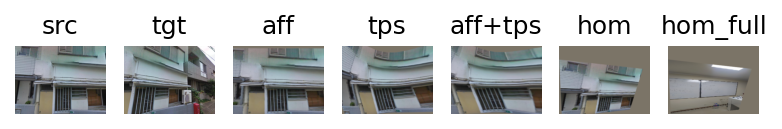

In [ ]:
do_aff=True
do_tps=True

N_subplots = 2+int(do_aff)+int(do_tps)+int(do_aff and do_tps)+int(do_hom*2)
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
subplot_idx = 2
if do_aff:
    axs[subplot_idx].imshow(warped_image_aff_np)
    axs[subplot_idx].set_title('aff')
    subplot_idx +=1 
if do_tps:
    axs[subplot_idx].imshow(warped_image_tps_np)
    axs[subplot_idx].set_title('tps')
    subplot_idx +=1 
if do_aff and do_tps:
    axs[subplot_idx].imshow(warped_image_aff_tps_np)
    axs[subplot_idx].set_title('aff+tps')
    subplot_idx +=1 
if do_hom:
    axs[subplot_idx].imshow(warped_image_hom_np)
    axs[subplot_idx].set_title('hom')
    subplot_idx +=1 
    axs[subplot_idx].imshow(full_warped_image_hom_np)
    axs[subplot_idx].set_title('hom_full')

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(150)
plt.show()

In [ ]:
warped_image_aff_np = warped_image_aff_np * 255
io.imsave("results/resultAff.jpg",warped_image_aff_np)

warped_image_tps_np = warped_image_tps_np * 255
io.imsave("results/resultTps.jpg",warped_image_tps_np)

warped_image_aff_tps_np = warped_image_aff_tps_np * 255
io.imsave("results/resultAff-Tps.jpg",warped_image_aff_tps_np)

warped_image_hom_np = warped_image_hom_np * 255
io.imsave("results/resultHom.jpg",warped_image_hom_np)

Lossy conversion from float32 to uint8. Range [9.008465766906738, 252.6087188720703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [9.22196102142334, 254.92288208007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.658336639404297, 252.32113647460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [9.20762825012207, 254.3977813720703]. Convert image to uint8 prior to saving to suppress this warning.
